In [37]:
import os
import torch
import numpy as np
from tkfilebrowser import askopenfilenames, askopendirname
import time
import matplotlib.pyplot as plt
import matplotlib
import cv2

from test.config_gnd import config_gnd
from test.test_utils import extract_feature, test_revisitop, print_top_n, create_groundtruth, rerank_ranks_revisitop
from test.dataset import DataSet
from core.CVNet_tester import setup_model
from core.checkpoint import load_checkpoint

from modules.reranking.MDescAug import MDescAug
from modules.reranking.RerankwMDA import RerankwMDA
import torch
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.manifold import TSNE

In [50]:
@torch.no_grad()
def test_model(encoder, device, data_dir, dataset_list, scale_list, custom, is_rerank, gemp, rgem, sgem):
    torch.backends.cudnn.benchmark = False
    model = setup_model(device, encoder)
    model.eval()
    torch.cuda.set_device(device)

    if encoder[0] == "":
        load_checkpoint(".\\weights\\CVPR2022_CVNet_R" + encoder[1] + ".pyth", model)
        state_dict = model.state_dict()
        model.load_state_dict(state_dict)
    
    # initialize modules
    MDescAug_obj = MDescAug(M=600, K=9)
    RerankwMDA_obj = RerankwMDA(M=600, K=9)
    
    for dataset in dataset_list:
        text = '>> {}: Global Retrieval for scale {} with CVNet-Global'.format(dataset, str(scale_list))
        #print(text)
        if custom:
            query_paths = askopenfilenames()
            data_dir = askopendirname()
            create_groundtruth(query_paths, data_dir)
            gnd_fn = 'custom.pkl'
            dataset = "custom"
        elif dataset == 'roxford5k':
            gnd_fn = 'gnd_roxford5k.pkl'
            file_path = 'revisitop/roxford5k/jpg/'
        elif dataset == 'rparis6k':
            gnd_fn = 'gnd_rparis6k.pkl'
        elif dataset == 'smartTrim':
            query_paths = [i for i in os.listdir(data_dir + 'queries/')]
            #dir_path = '/home/nick/Downloads/data/'
            create_groundtruth(query_paths, data_dir)
            gnd_fn = 'gnd_smartTrim.pkl'
        else:
            file_path = ''
            assert dataset
        print("extract query features")
        Q = extract_feature(model, data_dir, dataset, gnd_fn, "query", [1.0], gemp, rgem, sgem, scale_list)
        print("extract database features")
        X = extract_feature(model, data_dir, dataset, gnd_fn, "db", [1.0], gemp, rgem, sgem, scale_list)
    
    
        cfg = config_gnd(dataset, data_dir, custom)
        Q = torch.tensor(Q).cuda()
        X = torch.tensor(X).cuda()
    
        print("perform global feature reranking")
        sim = torch.matmul(X, Q.T)  # 6322 70
        ranks = torch.argsort(-sim, dim=0)  # 6322 70
    
        if is_rerank:
            rerank_dba_final, res_top1000_dba, ranks_trans_1000_pre, x_dba = MDescAug_obj(X, Q, ranks)
            ranks = RerankwMDA_obj(ranks, rerank_dba_final, res_top1000_dba, ranks_trans_1000_pre, x_dba)
        ranks = ranks.data.cpu().numpy()
    
        print_top_n(cfg, ranks, 5, file_path)
    
        # revisited evaluation
        ks = [1, 5, 10]
        if not custom:
            (mapE, _, _, _), (mapM, _, _, _), (mapH, _, _, _) = test_revisitop(cfg, ks, [ranks, ranks, ranks])
    
            print('Retrieval results: mAP E: {}, M: {}, H: {}'.format(np.around(mapE * 100, decimals=2),
                                                                      np.around(mapM * 100, decimals=2),
                                                                      np.around(mapH * 100, decimals=2)))


    return Q, X, ranks

In [43]:
labels = [
    "museum",
    "people",
    "museum",
    "people",
    "people",
    "museum",
    "museum",
    "museum",
    "museum",
    "museum",
    "museum",
    "museum",
    "museum",
    "museum",
    "museum",
    "museum",
    "museum",
    "museum",
    "dino",
    "building",
    "dino",  
    "museum",
    "museum",
    "query building",
    "museum",
    "tree",
    "people",
    "tree",
    "tree",
    "people",
    "museum",
    "museum",
    "museum",
    "museum",
    "people",
    "building",
    "museum",
    "museum",
    "query building",
    "people",
    "museum",
    "museum",
    "people",
    "museum",
    "museum",
    "museum",
    "museum",
    "building",
    "people",
    "museum",
    "museum",
    "museum",
    "museum",
    "museum",
    "museum",
    "query building",
    "museum",
    "people",
    "museum",
    "people",
    "building",
    "building",
    "dino",
    "query building",
    "museum",
    "building",
    "query building",
    "museum",
    "museum",
    "people",
    "people",
    "building",
    "museum",
    "museum",
    "people",
    "museum",
    "museum",
    "dino",
    "museum",
    "museum",
    "building",
    "building",
    "dino",
    "dino",
    "museum",
    "building",
    "museum",
    "museum",
    "museum",
    "building",
    "museum",
    "dino",
    "query building",
    "building",
    "museum",
    "building",
    "museum",
    "museum",
    "museum",
    "building",
    "museum",
    "people",
    "museum",
    "museum",
    "people",
    "museum",
    "people",
    "people"
]

In [44]:
mapping = {
        "museum": "r",
        "building": "b",
        "dino": "y",
        "tree": "g",
        "people": "purple",
        "query building": "pink"
              }

In [51]:
device = 0
data_dir = ".\\revisitop"
dataset_list = ["roxford5k"]
scale_list = 3
custom = False
is_rerank = False
gemp = True
rgem = True
sgem = True
depth = 101
encoder = ["", str(depth)]

Q_SG_rox, X_SG_rox, ranks_SG_rox = test_model(encoder, device, data_dir, dataset_list, scale_list, custom, is_rerank, gemp, rgem, sgem)

=> creating CVNet_Rerank model
CVNet_Rerank(
  (encoder_q): ResNet(
    (stem): ResStemIN(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (s1): ResStage(
      (b1): ResBlock(
        (proj): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (f): BottleneckTransform(
          (a): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (a_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (a_relu): relup()
          (b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (b_bn): BatchNorm2d(64, eps=1e-05, momentu

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\20163926\.conda\envs\SAM\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


extract database features


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:39<00:00,  1.09it/s]


perform global feature reranking
Retrieval results: mAP E: 4.49, M: 6.95, H: 3.32


In [52]:
device = 0
data_dir = ".\\revisitop"
dataset_list = ["roxford5k"]
scale_list = 3
custom = False
is_rerank = False
gemp = True
rgem = True
sgem = True
depth = 101
encoder = ["resnet", str(depth)]

Q_RN_rox, X_RN_rox, ranks_RN_rox = test_model(encoder, device, data_dir, dataset_list, scale_list, custom, is_rerank, gemp, rgem, sgem)

=> creating CVNet_Rerank model


Using cache found in C:\Users\20163926/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\20163926\.conda\envs\SAM\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\20163926\.conda\envs\SAM\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CVNet_Rerank(
  (encoder_q): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


extract database features


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:52<00:00,  2.06it/s]


perform global feature reranking
Retrieval results: mAP E: 4.49, M: 6.95, H: 3.32


In [53]:
device = 0
data_dir = ".\\revisitop"
dataset_list = ["roxford5k"]
scale_list = 3
custom = False
is_rerank = True
gemp = True
rgem = True
sgem = True
depth = 101
encoder = ["", str(depth)]

Q_SG_rox_r, X_SG_rox_r, ranks_SG_rox_r = test_model(encoder, device, data_dir, dataset_list, scale_list, custom, is_rerank, gemp, rgem, sgem)

=> creating CVNet_Rerank model
CVNet_Rerank(
  (encoder_q): ResNet(
    (stem): ResStemIN(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (s1): ResStage(
      (b1): ResBlock(
        (proj): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (f): BottleneckTransform(
          (a): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (a_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (a_relu): relup()
          (b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (b_bn): BatchNorm2d(64, eps=1e-05, momentu

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.70s/it]


extract database features


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:38<00:00,  1.10it/s]
C:\Users\20163926\Documents\TUe - Master - Year 2\Thesis\SuperGlobal\SuperGlobal\modules\reranking\MDescAug.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor1 = torch.tensor(X[ranks_trans_1000]).cuda()


perform global feature reranking
Retrieval results: mAP E: 4.49, M: 6.95, H: 3.32


In [54]:
device = 0
data_dir = ".\\revisitop"
dataset_list = ["roxford5k"]
scale_list = 3
custom = False
is_rerank = True
gemp = True
rgem = True
sgem = True
depth = 101
encoder = ["resnet", str(depth)]

Q_RN_rox_r, X_RN_rox_r, ranks_RN_rox_r = test_model(encoder, device, data_dir, dataset_list, scale_list, custom, is_rerank, gemp, rgem, sgem)

=> creating CVNet_Rerank model


Using cache found in C:\Users\20163926/.cache\torch\hub\pytorch_vision_v0.10.0


CVNet_Rerank(
  (encoder_q): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


extract database features


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:52<00:00,  2.05it/s]


perform global feature reranking
Retrieval results: mAP E: 4.49, M: 6.95, H: 3.32


In [55]:
def do_KNN(Q, X):
    # Use KNN to find the K nearest neighbors
    knn = NearestNeighbors(n_neighbors=10, metric='cosine')
    knn.fit(X.cpu())
    
    # Find the K nearest neighbors to the query image
    return knn.kneighbors(Q.cpu())

In [72]:
def do_TSNE(X, data, export=""):
    tsne = TSNE(n_components=2, verbose=1, perplexity=3)
    tsne_results = tsne.fit_transform(X.cpu())

    colors = []
    if data == "catsdogs":
        mapping_ = {
            "cat": "r",
            "dog": "b"
        }
        
        for i in range(X.shape[0]):
            if i < 0.5 * X.shape[0]:
                colors.append("r")
            else:
                colors.append("b")
    elif data == "roxford":
        mapping_ = mapping
        for i in labels:
            colors.append(mapping_[i])
            
    #-Create a-list-of Patch objects
    patches = [matplotlib.patches.Patch(color=color, label=label) for label, color in mapping_.items()]
    
    plt.figure(figsize=(10, 10))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors)
    plt.legend(handles=patches)
    if export != "":
        plt.savefig(export + ".png", bbox_inches='tight')

    plt.show()

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.001s...
[t-SNE] Computed neighbors for 108 samples in 0.125s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 0.162586
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.701530
[t-SNE] KL divergence after 1000 iterations: 0.568857


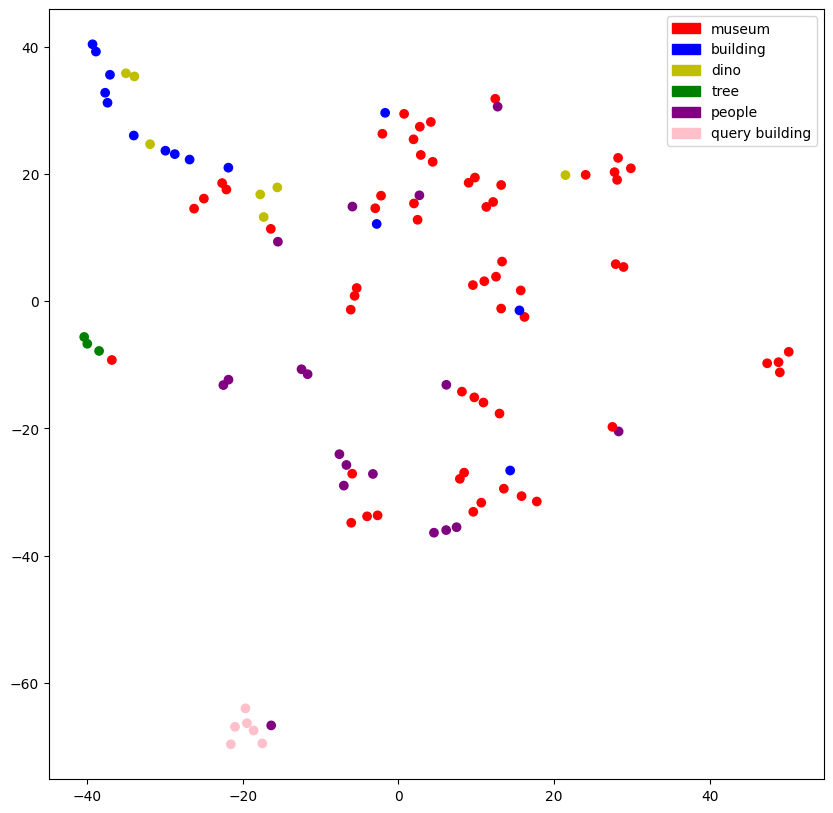

In [65]:
do_TSNE(X_SG_rox, "roxford", "SG_rox")

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.002s...
[t-SNE] Computed neighbors for 108 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 0.162586
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.892731
[t-SNE] KL divergence after 1000 iterations: 0.585740


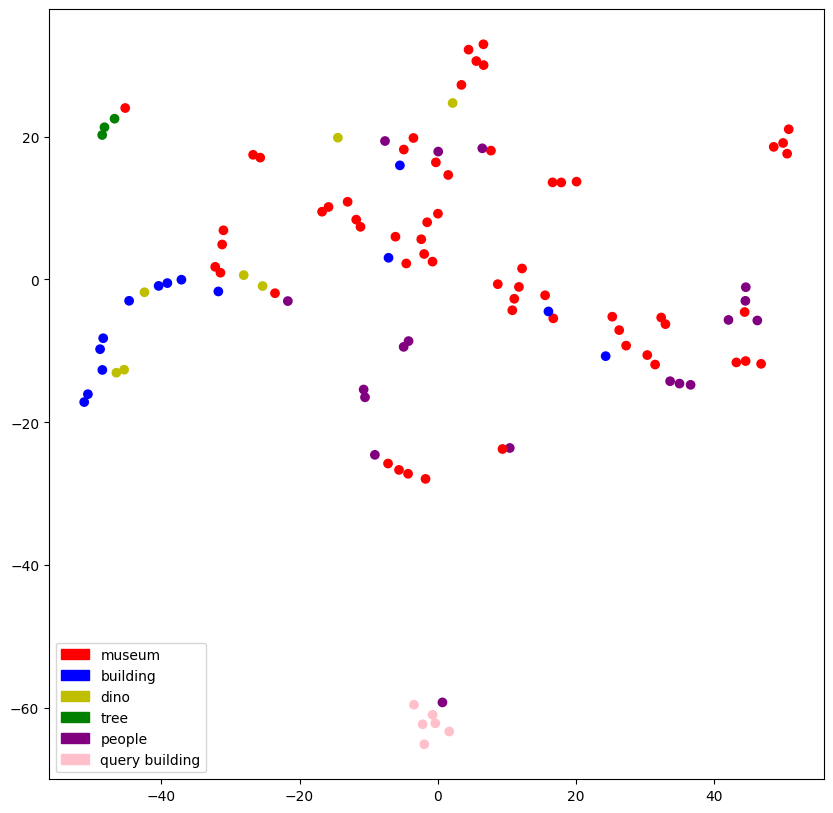

In [66]:
do_TSNE(X_SG_rox_r, "roxford", "SG_rox_rerank")

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.001s...
[t-SNE] Computed neighbors for 108 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 0.191059
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.826546
[t-SNE] KL divergence after 1000 iterations: 0.528866


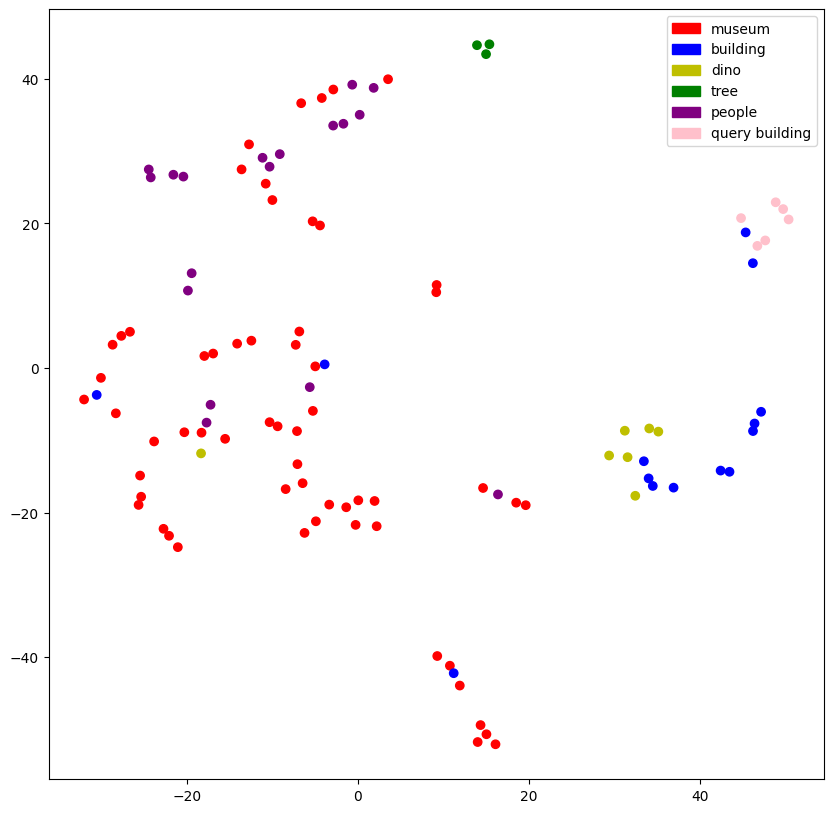

In [67]:
do_TSNE(X_RN_rox, "roxford", "RN_rox")

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.001s...
[t-SNE] Computed neighbors for 108 samples in 0.118s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 0.191059
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.500549
[t-SNE] KL divergence after 1000 iterations: 0.533160


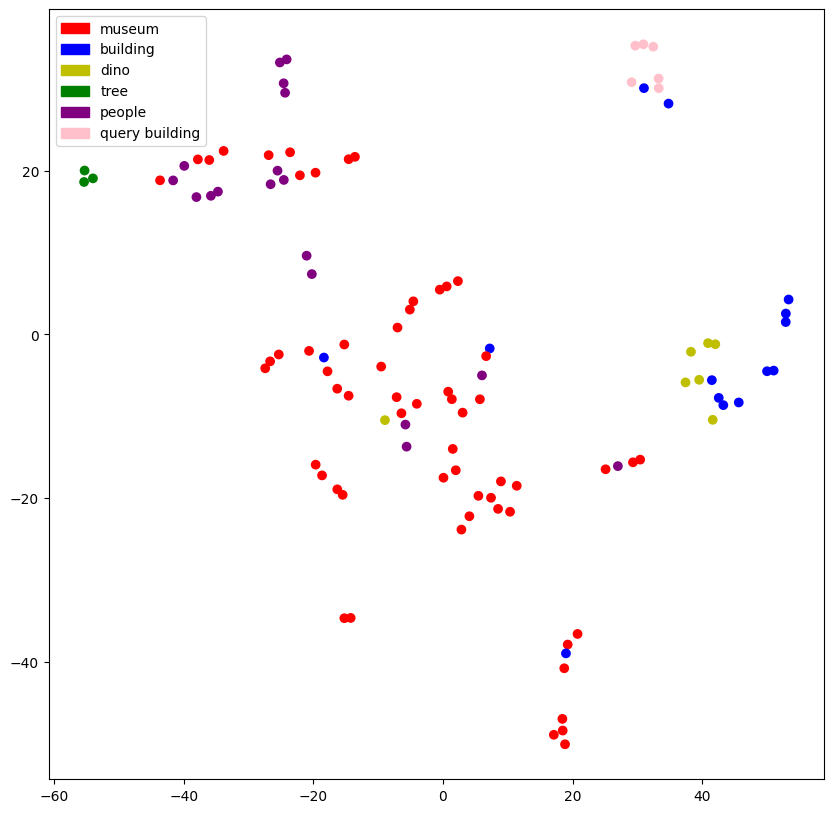

In [68]:
do_TSNE(X_RN_rox_r, "roxford", "RN_rox_rerank")

In [13]:
def resize_and_pad(image, new_shape=(144, 144), padding_color=(0, 0, 0)):
    # Calculate the ratio to resize the image
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape)) / max(original_shape)
    new_size = tuple([int(x * ratio) for x in original_shape])
    
    # Resize the image
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
    
    # Calculate the padding needed to make the image at least 144x144
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    
    # Add padding to the image
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    
    return image

In [14]:
@torch.no_grad()
def get_features(data, sets, num, model, gemp, rgem, sgem, scale_list):
    out = []
    for set in sets:
        directory = data + set + '\\'
        feats = []

        #  # List to store image file names
        # image_files = []
    
        # # List of image file extensions
        # image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    
        # # Iterate over all files in the directory
        # for filename in os.listdir(directory):
        #     # Check if the file has an image extension
        #     if any(filename.endswith(ext) for ext in image_extensions):
        #         # Add the file to the list
        #         image_files.append(os.path.join(directory, filename))
        
        for cur in tqdm(range(size)):
            img = cv2.imread(directory+str(cur)+".jpg")
            try:
                if img.shape[0] < 144 or img.shape[1] < 144:
                    img = resize_and_pad(img)
            except AttributeError:
                print(img)
                print(cur)
                break
                # Convert the image from BGR to RGB
                #img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Display the image using Matplotlib
                #plt.imshow(img_rgb)
                #plt.show()
            image = torch.transpose(torch.transpose(torch.Tensor([img]), 1,3), 2,3)
            feat = model(image)
            #model.extract_global_descriptor(image.cuda(), gemp, rgem, sgem, scale_list)
            feats.append(feat.detach().cpu())
        out.append(feats)
    return torch.stack([torch.stack(out[0]), torch.stack(out[1])]).squeeze(2).reshape(size*2, 1000)

In [15]:
size = 500
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
X_RN_cd = get_features(".\\revisitop\\catndogs\\PetImages\\", ['Cat','Dog'], size, model, gemp, rgem, sgem, scale_list)

Using cache found in C:\Users\20163926/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\20163926\.conda\envs\SAM\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\20163926\.conda\envs\SAM\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\20163926\AppData\Local\Temp\ipykernel_21424\929914904.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Ple

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.148s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.308901
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.041428
[t-SNE] KL divergence after 1000 iterations: 1.712856


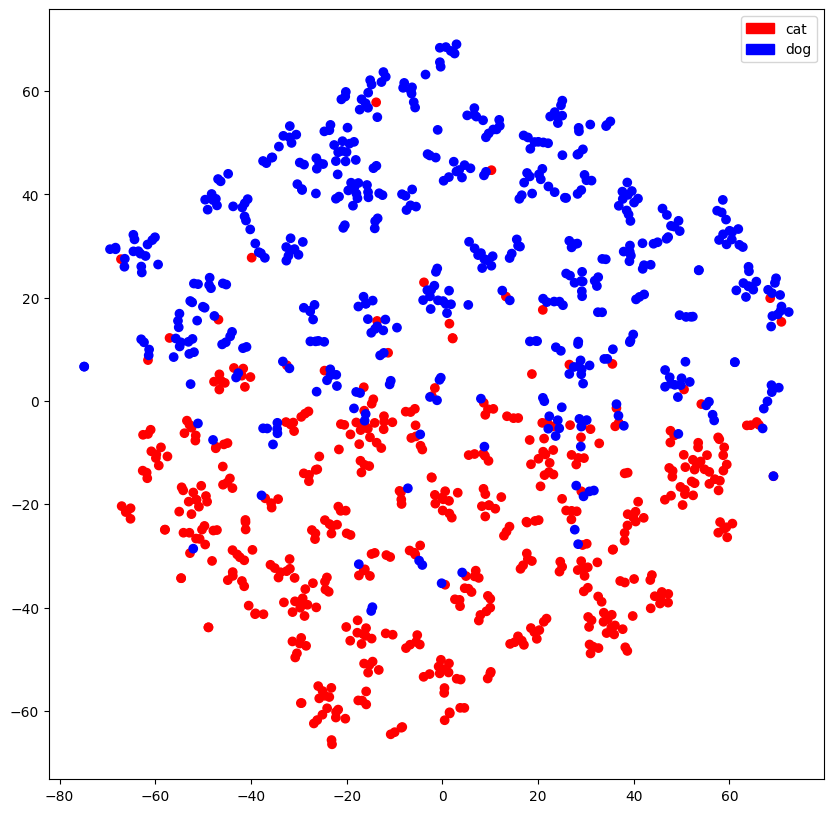

In [73]:
do_TSNE(X_RN_cd, "catsdogs", "RN_cd")

In [17]:
size = 500
model = ""
X_SG_cd = get_features(".\\revisitop\\catndogs\\PetImages\\", ['Cat','Dog'], size, model, gemp, rgem, sgem, scale_list)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]


TypeError: 'str' object is not callable